# <center> Project2 </center>

In [1]:
# 所有包
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from visualize.model_utils import create_class_visualization, show_saliency_maps

## <center> 1.1 Getting Started </center>
you may download the dataset from the official website [2] or use the torchvision package. Here is a demo
provided by PyTorch [1]

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Calculate lengths for training and validation sets
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size

# Split the dataset
torch.manual_seed(43)
trainset, valset = random_split(trainset, [train_size, val_size])
batch_size = 256
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

# Classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


可视化一下

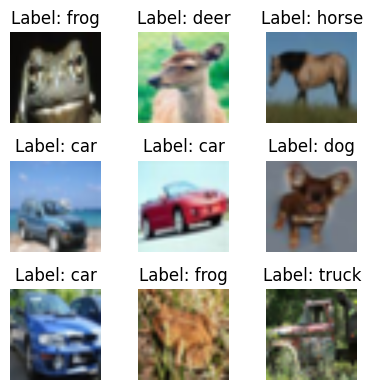

In [109]:

def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

fig, axes = plt.subplots(3, 3, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    img, label = trainset[i]
    imshow(img, ax)
    ax.set_title(f"Label: {classes[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## <center> 1.2 create networks </center>

所有组件：

In [4]:

## Resnet Block 
class Resblock(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super(Resblock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Initialize weights
        # self._initialize_weights()
        
    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)
    
    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        if self.conv3:
            nn.init.kaiming_normal_(self.conv3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn1.weight, 1)
        nn.init.constant_(self.bn1.bias, 0)
        nn.init.constant_(self.bn2.weight, 1)
        nn.init.constant_(self.bn2.bias, 0)
        
class Convblock(nn.Module):
    def __init__(self, input_channels, num_channels, strides = 1):
        super(Convblock, self).__init__()
        self.conv = nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=3, padding=1, stride=strides)
        self.bn = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Initialize weights
        # self._initialize_weights()

    def forward(self, X):
        return self.relu(self.bn(self.conv(X)))
    
    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

def resnet_block(input_channels, num_channels, num_res, first_block = False):
    block = []
    for i in range(num_res):
        if i == 0 and not first_block: # 只有第一个高宽减半
            block.append(
                Resblock(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            block.append(Resblock(num_channels, num_channels))
    
    return block

net主体：

In [45]:
class mynet(nn.Module):
    def __init__(self, cfg = ["R", "R",  "R"], output_channel = 512, output_feature = 98, Global_pool = False):
        super(mynet, self).__init__()
        self.Global = Global_pool
        self.cfg = cfg
        ## 第一层
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # 有无平均池化
        if Global_pool:
            self.classifier = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Conv2d(256, 10, kernel_size=1)
            )
        else:
            self.classifier = nn.Sequential(
                    nn.Dropout(0.8),
                    nn.Linear(output_channel*output_feature, 1024),
                    nn.Linear(1024, 10)
            )
        self.input_channel = 64
        self.layers = self.make_layer()
    def make_layer(self):
        layers = []
        for i in range(len(self.cfg)):
            if self.cfg[i] == "R":
                if i == 0 or self.cfg[i-1] != "R": # 如果前面高宽减半就别再res里减半
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel, 2, first_block=True)))

                else:
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel*2, 2)))
                    self.input_channel *= 2
                
            else:
                layers.append(Convblock(self.input_channel, self.input_channel*2, 2))
                self.input_channel *= 2 
        return nn.Sequential(*layers)
        
    def result(self, x):
        results = []
        out = self.b1(x)
        results.append(out)
        out = self.layers(out)
        results.append(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)  
            results.append(out)
        else:
            out = out.view(out.size(0), -1)
            results.append(out)
            out = self.classifier(out)
            results.append(out)
        return results
    
    def forward(self, x):
        out = self.b1(x)
        out = self.layers(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)  
        else:
            out = out.view(out.size(0), -1)
            out = self.classifier(out)
        return out

示例层数及参数：

In [46]:
## 打印示例层数：
# 如果用了最后一层用了Global
print("-"*10, "with Global", "-"*10 )
net = mynet(Global_pool=True)
x = torch.randn(1, 3, 224, 224)  
outputs = net.result(x)
for i, output in enumerate(outputs):
    print(f"Output of stage {i}: {output.shape}")

print("-"*10, "without global", "-"*10)
net = mynet()
x = torch.randn(1, 3, 224, 224)  
outputs = net.result(x)
for i, output in enumerate(outputs):
    print(f"Output of stage {i}: {output.shape}")


---------- with Global ----------
Output of stage 0: torch.Size([1, 64, 56, 56])
Output of stage 1: torch.Size([1, 256, 14, 14])
Output of stage 2: torch.Size([1, 10])
---------- without global ----------
Output of stage 0: torch.Size([1, 64, 56, 56])
Output of stage 1: torch.Size([1, 256, 14, 14])
Output of stage 2: torch.Size([1, 50176])
Output of stage 3: torch.Size([1, 10])


超参数：

In [49]:
# 超参数的设定
batch_size = 256
num_epochs = 20   # 训练轮数
learning_rate = 1e-3        # 初始学习率
test_net = mynet(Global_pool=True)
if torch.cuda.is_available():
    test_net = test_net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 学习率调整策略 MultiStep：
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                           milestones=[int(num_epochs * 0.36), int(num_epochs * 0.78)],
                                           gamma=0.1, last_epoch=-1)

训练与验证：

In [8]:
import time 
def train0(net, trainloader, valloader, num_epochs,optimizer,scheduler):

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val = 0
    max_model = None
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        net.train()  # 设置为训练模式
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # 验证阶段
        net.eval()  # 设置为评估模式
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        scheduler.step()
        if max_val < val_acc:
            max_val = val_acc
            max_model = net
            torch.save(net.state_dict(), 'checkpoint/cifar10_test_mynet1.pth')
        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')

    return max_model, train_losses, train_accuracies, val_accuracies

In [119]:
test_net, train_losses, train_accuracies, val_accuracies = train0(test_net, trainloader, valloader, num_epochs, optimizer=optimizer, scheduler=scheduler)

Epoch: 1/20
Epoch [1/20], Train Loss: 1.7340, Train Acc: 39.40%, Val Acc: 52.14%, Time: 45.283s
Epoch: 2/20
Epoch [2/20], Train Loss: 1.2734, Train Acc: 54.12%, Val Acc: 60.16%, Time: 45.513s
Epoch: 3/20
Epoch [3/20], Train Loss: 1.0995, Train Acc: 60.48%, Val Acc: 63.78%, Time: 45.617s
Epoch: 4/20
Epoch [4/20], Train Loss: 0.9844, Train Acc: 64.90%, Val Acc: 64.20%, Time: 45.961s
Epoch: 5/20
Epoch [5/20], Train Loss: 0.8875, Train Acc: 68.61%, Val Acc: 68.94%, Time: 46.163s
Epoch: 6/20
Epoch [6/20], Train Loss: 0.8101, Train Acc: 71.27%, Val Acc: 71.66%, Time: 45.894s
Epoch: 7/20
Epoch [7/20], Train Loss: 0.7450, Train Acc: 73.63%, Val Acc: 70.76%, Time: 45.542s
Epoch: 8/20
Epoch [8/20], Train Loss: 0.6476, Train Acc: 77.20%, Val Acc: 75.30%, Time: 46.270s
Epoch: 9/20
Epoch [9/20], Train Loss: 0.6262, Train Acc: 77.92%, Val Acc: 76.18%, Time: 46.200s
Epoch: 10/20
Epoch [10/20], Train Loss: 0.6137, Train Acc: 78.35%, Val Acc: 76.42%, Time: 46.479s
Epoch: 11/20
Epoch [11/20], Train Loss

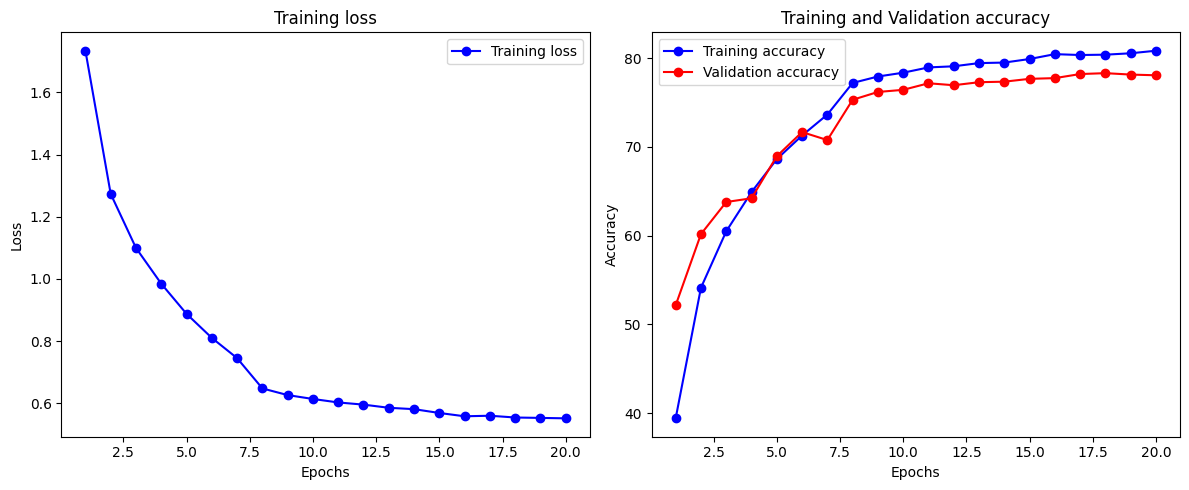

In [120]:
# 绘制损失和准确率
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [121]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 77.88%


上面测试网络的结构是：
一个卷积块+4个ResBlock+两层fc

In [9]:
print(test_net)

mynet(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=50176, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (0): Resblock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Resblock(
        (conv1): Conv2

## <center> 1.3 try different strategies </center>

### <center> 1.2.1 Try different number of neurons/filters </center>
我们尝试三种结构：
* [R,R,R]
* [R,C,R]
* [R,C,C]

并绘制在同一个表格里

In [20]:
class diffnet(nn.Module):
    def __init__(self, cfg = ["R",  128, 256], output_channel = 256, output_feature = 196, Global_pool = False):
        super(diffnet, self).__init__()
        self.Global = Global_pool
        self.cfg = cfg
        ## 第一层
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # 有无平均池化
        if Global_pool:
            self.classifier = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Conv2d(output_channel, 10, kernel_size=1)
            )
        else:
            self.classifier = nn.Sequential(
                    nn.Dropout(0.8),
                    nn.Linear(output_channel*output_feature, 1024),
                    nn.Linear(1024, 10)
            )
        self.input_channel = 64
        self.layers = self.make_layer()
    def make_layer(self):
        layers = []
        for i in range(len(self.cfg)):
            if self.cfg[i] == "R":
                if i == 0 or self.cfg[i-1] != "R": # 如果前面高宽减半就别再res里减半
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel, 2, first_block=True)))

                else:
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel*2, 2)))
                    self.input_channel *= 2
                
            else:
                layers.append(Convblock(self.input_channel, self.input_channel*2, 2))
                self.input_channel *= 2 
        return nn.Sequential(*layers)
        
    def result(self, x):
        results = []
        out = self.b1(x)
        results.append(out)
        out = self.layers(out)
        results.append(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)  
            results.append(out)
        else:
            out = out.view(out.size(0), -1)
            results.append(out)
            out = self.classifier(out)
            results.append(out)
        return results
    
    def forward(self, x):
        out = self.b1(x)
        out = self.layers(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)  
        else:
            out = out.view(out.size(0), -1)
            out = self.classifier(out)
        return out

In [22]:
def train_and_evaluate(cfg, output_channel, output_feature, criterion, learning_rate, num_epochs=4, global_pool=False):
    net = diffnet(cfg, output_channel=output_channel, output_feature=output_feature, Global_pool=global_pool)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-3)
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val = 0
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        
        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')
        if val_acc > max_val:
            max_val = val_acc
            torch.save(net.state_dict(), 'checkpoint/cifar10_diffnet_{}.pth'.format(cfg))
    
    return train_losses, train_accuracies, val_accuracies


In [25]:
# 超参数的设定
epochs = 15   # 训练轮数
learning_rate = 1e-3       # 初始学习率
cri = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [337]:
# 训练和评估每个配置
configs = [
    ["R", "R", "R", "R"],
    ["R", "R", "R", 512],
    ["R", "R", 256, 512]
]
results = []
for cfg in configs:
    print(f'Training with configuration: {cfg}')
    train_losses, train_accuracies, val_accuracies = train_and_evaluate(cfg, criterion=cri, learning_rate=learning_rate,
                                                                        output_channel = 512, output_feature = 49, num_epochs=epochs, global_pool=False)
    results.append((train_losses, train_accuracies, val_accuracies))

Training with configuration: ['R', 'R', 'R', 'R']
Epoch: 1/15
Epoch [1/15], Train Loss: 2.4372, Train Acc: 19.23%, Val Acc: 28.34%, Time: 220.127s
Epoch: 2/15
Epoch [2/15], Train Loss: 1.8170, Train Acc: 33.07%, Val Acc: 38.56%, Time: 209.907s
Epoch: 3/15
Epoch [3/15], Train Loss: 1.6578, Train Acc: 38.71%, Val Acc: 37.56%, Time: 219.126s
Epoch: 4/15
Epoch [4/15], Train Loss: 1.5940, Train Acc: 41.36%, Val Acc: 42.76%, Time: 219.622s
Epoch: 5/15
Epoch [5/15], Train Loss: 1.5670, Train Acc: 42.13%, Val Acc: 46.52%, Time: 217.762s
Epoch: 6/15
Epoch [6/15], Train Loss: 1.5501, Train Acc: 43.06%, Val Acc: 47.68%, Time: 220.286s
Epoch: 7/15
Epoch [7/15], Train Loss: 1.5269, Train Acc: 44.02%, Val Acc: 42.94%, Time: 217.052s
Epoch: 8/15
Epoch [8/15], Train Loss: 1.5148, Train Acc: 44.65%, Val Acc: 48.98%, Time: 216.145s
Epoch: 9/15
Epoch [9/15], Train Loss: 1.5007, Train Acc: 44.96%, Val Acc: 42.54%, Time: 218.266s
Epoch: 10/15
Epoch [10/15], Train Loss: 1.4935, Train Acc: 45.42%, Val Acc: 4

In [20]:
import matplotlib.pyplot as plt

def plot_training_results(results, epochs, configs):
    """
    绘制训练和验证结果。"""
    epochs_r = range(1, epochs + 1)
    plt.figure(figsize=(18, 6))

    for i, (train_losses, train_accuracies, val_accuracies) in enumerate(results):
        config = configs[i]
        # 绘制训练损失
        plt.subplot(1, 3, 1)
        plt.plot(epochs_r, train_losses, label=f'Config {i+1}: {config}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # 绘制训练准确率
        plt.subplot(1, 3, 2)
        plt.plot(epochs_r, train_accuracies, label=f'Config {i+1}: {config}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        # 绘制验证准确率
        plt.subplot(1, 3, 3)
        plt.plot(epochs_r, val_accuracies, label=f'Config {i+1}: {config}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

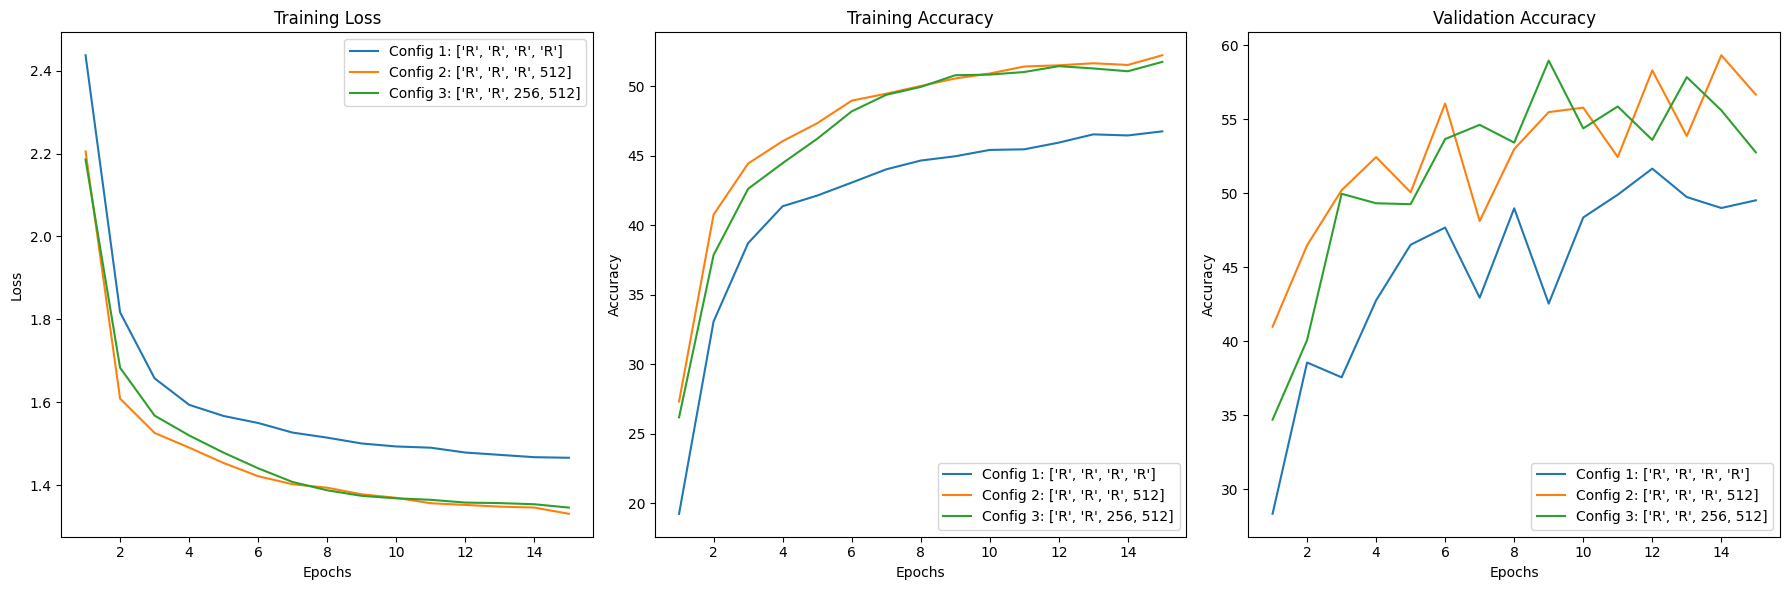

In [342]:
plot_training_results(results, epochs, configs)

### <center>1.2.1 Try different loss functions (with different regularization) </center>

为了加速训练 我们直接固定一个训练网络：

In [27]:
class diffnet2(nn.Module):
    def __init__(self, output_channel = 512, output_feature = 49, Global_pool = False):
        super(diffnet2, self).__init__()
        self.Global = Global_pool
        ## 第一层
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # 有无平均池化
        if Global_pool:
            self.classifier = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Conv2d(output_channel, 10, kernel_size=1)
            )
        else:
            self.classifier = nn.Sequential(
                    nn.Dropout(0.8),
                    nn.Linear(output_channel*output_feature, 1024),
                    nn.Linear(1024, 10)
            )
        self.res1 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        self.res2 = nn.Sequential(*resnet_block(64, 128, 2))
        self.res3 = nn.Sequential(*resnet_block(128, 256, 2))
        self.Conv = nn.Sequential(
                    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, padding=1, stride=2),
                    nn.BatchNorm2d(512),
                    nn.ReLU(inplace=True)
                )
        
    def forward(self, x):
        out = self.b1(x)
        out = self.res3(self.res2(self.res1(out)))
        out = self.Conv(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)  
        else:
            out = out.view(out.size(0), -1)
            out = self.classifier(out)
        return out

In [28]:
def train_and_evaluate2(learning_rate, loss_fn='cross_entropy', regularization=None, reg_lambda=0.01, num_epochs=4):
    net = diffnet2()
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # 选择损失函数
    if loss_fn == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()
    elif loss_fn == 'mse':
        criterion = nn.MSELoss()
    else:
        raise ValueError(f'Unknown loss function: {loss_fn}')

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val = 0
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"Epoch: {epoch + 1}/{num_epochs}")
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            # 对于 MSE Loss，需要将标签转换为 one-hot 编码
            if loss_fn == 'mse':
                labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)

            # 添加正则化项（L2 正则化）
            if regularization == 'l2':
                l2_reg = torch.tensor(0., requires_grad=True)
                for param in net.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)
                loss = loss + reg_lambda * l2_reg

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')
        if val_acc > max_val:
            max_val = val_acc
            torch.save(net.state_dict(), 'checkpoint/cifar10_diffnet2_{}_reg_{}.pth'.format(loss_fn, regularization))

    return train_losses, train_accuracies, val_accuracies

In [29]:
loss_functions = ['mse', 'cross_entropy',]
regularizations = ['l2', None, ]
train_loss_results = {}
train_acc_results = {}
val_acc_results = {}
for loss_fn in loss_functions:
    for reg in regularizations:
        key = f' Loss: {loss_fn}, Reg: {reg}'
        print(f'Training with configuration: {key}')
        train_losses, train_accuracies, val_accuracies = train_and_evaluate2(learning_rate, loss_fn=loss_fn, regularization=reg, num_epochs=epochs)
        train_loss_results[key] = train_losses
        train_acc_results[key] = train_accuracies
        val_acc_results[key] = val_accuracies

Training with configuration:  Loss: mse, Reg: l2
Epoch: 1/15
Epoch [1/15], Train Loss: 10.6323, Train Acc: 13.35%, Val Acc: 24.62%, Time: 47.427s
Epoch: 2/15
Epoch [2/15], Train Loss: 3.3082, Train Acc: 23.87%, Val Acc: 29.78%, Time: 46.603s
Epoch: 3/15
Epoch [3/15], Train Loss: 3.2660, Train Acc: 31.22%, Val Acc: 35.86%, Time: 46.603s
Epoch: 4/15
Epoch [4/15], Train Loss: 3.2197, Train Acc: 35.91%, Val Acc: 32.46%, Time: 51.907s
Epoch: 5/15
Epoch [5/15], Train Loss: 3.1723, Train Acc: 38.92%, Val Acc: 42.12%, Time: 67.082s
Epoch: 6/15
Epoch [6/15], Train Loss: 3.1216, Train Acc: 41.68%, Val Acc: 43.96%, Time: 65.456s
Epoch: 7/15
Epoch [7/15], Train Loss: 3.0694, Train Acc: 43.24%, Val Acc: 45.16%, Time: 63.976s
Epoch: 8/15
Epoch [8/15], Train Loss: 3.0122, Train Acc: 45.40%, Val Acc: 45.42%, Time: 46.315s
Epoch: 9/15
Epoch [9/15], Train Loss: 2.9533, Train Acc: 46.10%, Val Acc: 47.36%, Time: 44.347s
Epoch: 10/15
Epoch [10/15], Train Loss: 2.8917, Train Acc: 47.91%, Val Acc: 49.14%, Ti

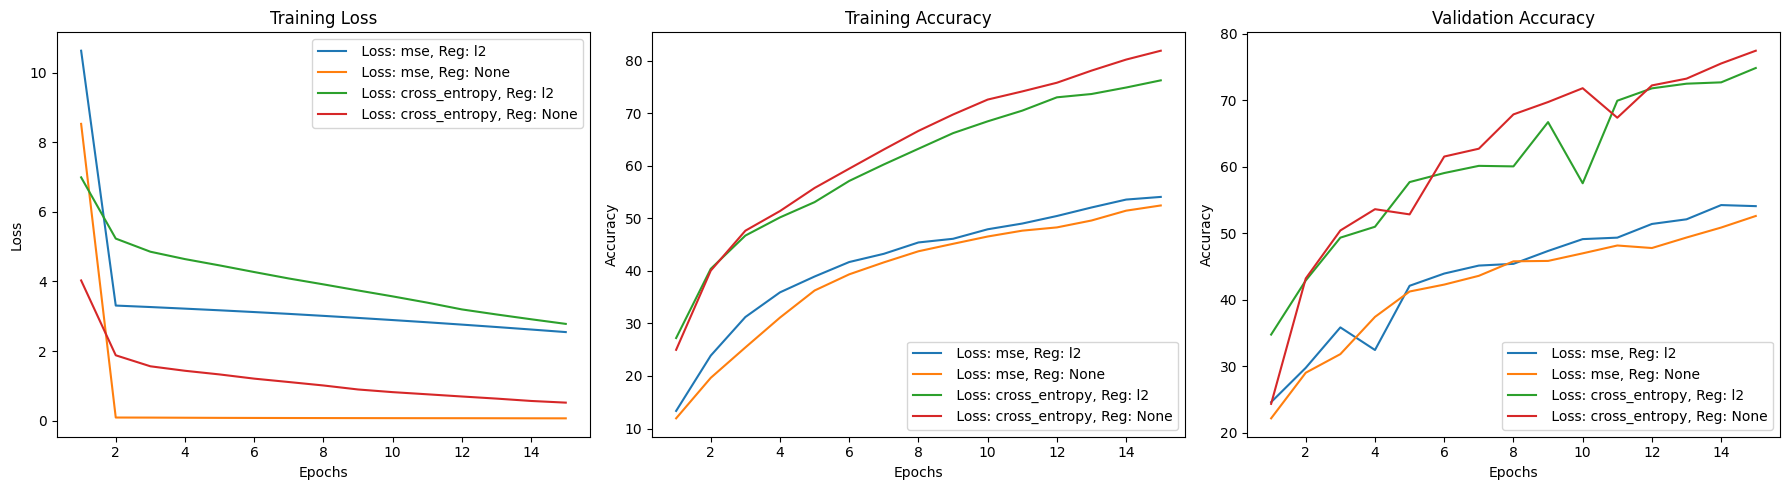

In [30]:
# 绘制结果
epochs_r = range(1, epochs+1)
plt.figure(figsize=(18, 5))

# 绘制训练损失
plt.subplot(1, 3, 1)
for key, losses in train_loss_results.items():
    plt.plot(epochs_r, losses, label=key)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 绘制训练准确率
plt.subplot(1, 3, 2)
for key, accuracies in train_acc_results.items():
    plt.plot(epochs_r, accuracies, label=key)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# 绘制验证准确率
plt.subplot(1, 3, 3)
for key, accuracies in val_acc_results.items():
    plt.plot(epochs_r, accuracies, label=key)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <center> 1.2.3 Try different activations </center>

同样用上面的网络 loss_fun是cross_entropy，不加reg

In [11]:
activation_functions = {
    'relu': nn.ReLU,
    'leaky_relu': nn.LeakyReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh
}
class Resblock2(nn.Module):
    def __init__(self, input_channels, num_channels, activation, use_1x1conv=False, strides=1):
        super(Resblock2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 检查激活函数是否支持 inplace 参数
        if activation in [nn.ReLU, nn.LeakyReLU]:
            self.activation = activation(inplace=True)
        else:
            self.activation = activation()

    def forward(self, X):
        Y = self.activation(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.activation(Y)

def resnet_block2(input_channels, num_channels, num_res, activation,first_block = False):
    block = []
    for i in range(num_res):
        if i == 0 and not first_block: # 只有第一个高宽减半
            block.append(
                Resblock2(input_channels, num_channels, activation, use_1x1conv=True, strides=2))
        else:
            block.append(Resblock2(num_channels, num_channels, activation))
    
    return block

In [12]:
class diffnet3(nn.Module):
    def __init__(self, activation, output_channel = 512, output_feature = 49):
        super(diffnet3, self).__init__()
                # 检查激活函数是否支持 inplace 参数
        if activation in [nn.ReLU, nn.LeakyReLU]:
            activation_layer = activation(inplace=True)
        else:
            activation_layer = activation()
        self.activation = activation
        ## 第一层
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding = 3),
            nn.BatchNorm2d(64), self.activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.classifier = nn.Sequential(
                nn.Dropout(0.8),
                nn.Linear(output_channel*output_feature, 1024),
                nn.Linear(1024, 10)
        )
        self.res1 = nn.Sequential(*resnet_block2(64, 64, 2, self.activation, first_block=True))
        self.res2 = nn.Sequential(*resnet_block2(64, 128, 2, activation))
        self.res3 = nn.Sequential(*resnet_block2(128, 256, 2, activation))
        self.Conv = nn.Sequential(
                    nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, padding=1, stride=2),
                    nn.BatchNorm2d(512),
                    activation_layer
                )
        
    def forward(self, x):
        out = self.b1(x)
        out = self.res3(self.res2(self.res1(out)))
        out = self.Conv(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [15]:
import time
def train_and_evaluate3( learning_rate, activation_name, num_epochs=4):
    activation = activation_functions[activation_name]
    net = diffnet3(activation)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-3)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        
        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')
        torch.save(net.state_dict(), 'checkpoint/cifar10_diffnet3_{}.pth'.format(activation_name))
    
    return train_losses, train_accuracies, val_accuracies


In [18]:
activations = [ 'relu', 'sigmoid','tanh','leaky_relu']
results3 = []
for act in activations:
    print(f'Training with activations: {act}')
    train_losses, train_accuracies, val_accuracies = train_and_evaluate3(learning_rate=learning_rate, activation_name = act, num_epochs=epochs)
    results3.append((train_losses, train_accuracies, val_accuracies))

Training with activations: relu
Epoch: 1/15
Epoch [1/15], Train Loss: 2.1825, Train Acc: 27.03%, Val Acc: 33.50%, Time: 214.621s
Epoch: 2/15
Epoch [2/15], Train Loss: 1.6344, Train Acc: 40.06%, Val Acc: 44.38%, Time: 215.516s
Epoch: 3/15
Epoch [3/15], Train Loss: 1.5429, Train Acc: 43.55%, Val Acc: 48.76%, Time: 218.056s
Epoch: 4/15
Epoch [4/15], Train Loss: 1.4758, Train Acc: 46.54%, Val Acc: 53.94%, Time: 215.998s
Epoch: 5/15
Epoch [5/15], Train Loss: 1.4450, Train Acc: 47.92%, Val Acc: 51.76%, Time: 216.155s
Epoch: 6/15
Epoch [6/15], Train Loss: 1.4206, Train Acc: 48.69%, Val Acc: 54.90%, Time: 215.344s
Epoch: 7/15
Epoch [7/15], Train Loss: 1.3855, Train Acc: 50.06%, Val Acc: 52.44%, Time: 214.502s
Epoch: 8/15
Epoch [8/15], Train Loss: 1.3709, Train Acc: 50.86%, Val Acc: 56.36%, Time: 215.149s
Epoch: 9/15
Epoch [9/15], Train Loss: 1.3603, Train Acc: 51.25%, Val Acc: 54.02%, Time: 214.663s
Epoch: 10/15
Epoch [10/15], Train Loss: 1.3524, Train Acc: 51.30%, Val Acc: 50.26%, Time: 215.3

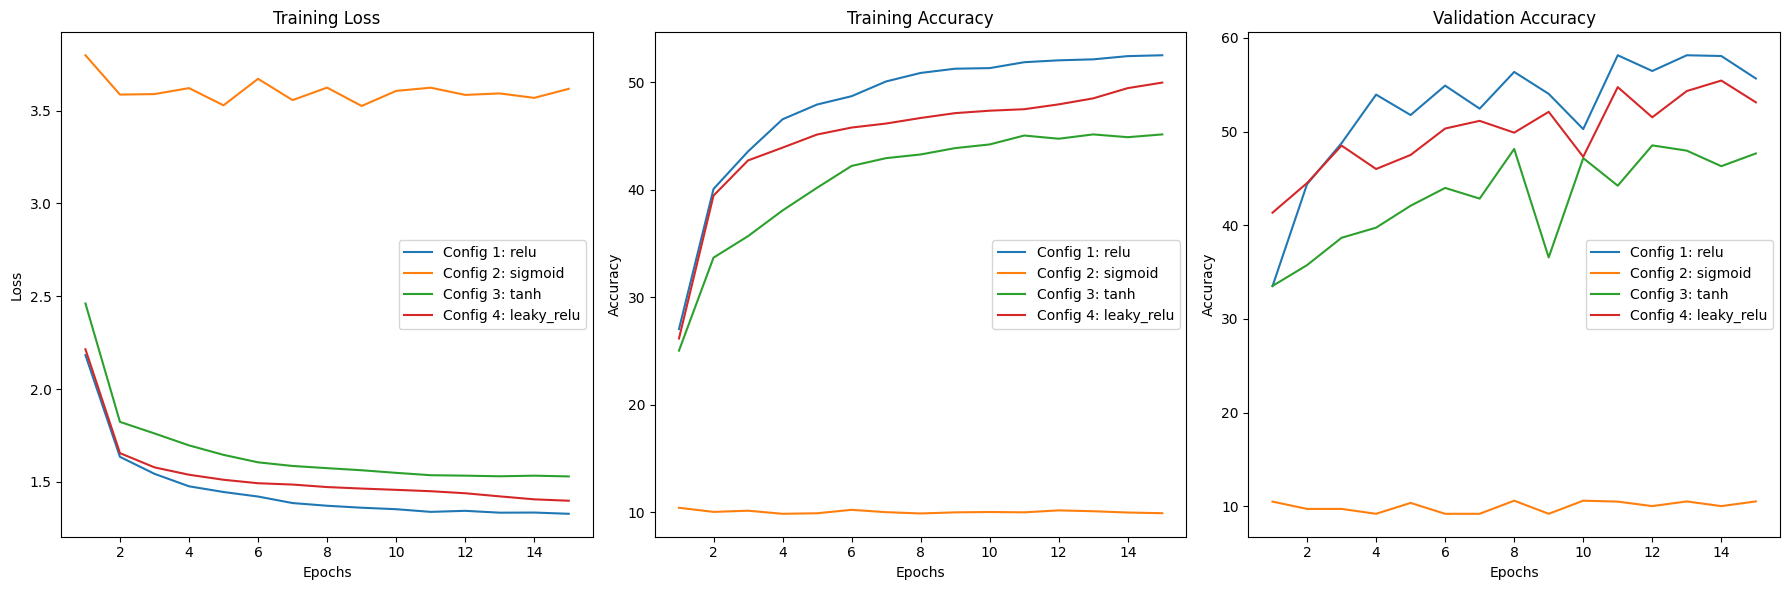

In [21]:
plot_training_results(results3, epochs, activations)

### <center> 1.2.4 Try different optimizers using torch.optim </center>

In [185]:
def train_and_evaluate4(learning_rate, optimizer_name, num_epochs=4, global_pool=False):
    net = mynet()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-3)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-3)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=5e-3)
    else:
        raise ValueError(f'Unknown optimizer: {optimizer_name}')
    
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        
        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')
        torch.save(net.state_dict(), 'checkpoint/cifar10_diffnet_{}.pth'.format(optimizer_name))
    
    return train_losses, train_accuracies, val_accuracies


In [186]:
optimizers = ['sgd', 'rmsprop', 'adam']
results4 = []
for opt in optimizers:
    print(f'Training with optimizer: {opt}')
    train_losses, train_accuracies, val_accuracies = train_and_evaluate4(learning_rate=learning_rate, optimizer_name= opt, num_epochs=epochs)
    results4.append((train_losses, train_accuracies, val_accuracies))

Training with optimizer: sgd
Epoch: 1/15
Epoch [1/15], Train Loss: 2.1248, Train Acc: 30.20%, Val Acc: 46.68%, Time: 218.156s
Epoch: 2/15
Epoch [2/15], Train Loss: 1.3562, Train Acc: 51.66%, Val Acc: 62.62%, Time: 213.450s
Epoch: 3/15
Epoch [3/15], Train Loss: 1.0383, Train Acc: 63.56%, Val Acc: 68.72%, Time: 215.742s
Epoch: 4/15
Epoch [4/15], Train Loss: 0.8861, Train Acc: 69.02%, Val Acc: 73.32%, Time: 215.768s
Epoch: 5/15
Epoch [5/15], Train Loss: 0.8089, Train Acc: 71.79%, Val Acc: 71.70%, Time: 217.096s
Epoch: 6/15
Epoch [6/15], Train Loss: 0.7633, Train Acc: 73.79%, Val Acc: 75.62%, Time: 217.588s
Epoch: 7/15
Epoch [7/15], Train Loss: 0.7249, Train Acc: 75.04%, Val Acc: 74.74%, Time: 223.316s
Epoch: 8/15
Epoch [8/15], Train Loss: 0.6989, Train Acc: 76.14%, Val Acc: 76.50%, Time: 219.388s
Epoch: 9/15
Epoch [9/15], Train Loss: 0.6761, Train Acc: 76.89%, Val Acc: 76.54%, Time: 219.372s
Epoch: 10/15
Epoch [10/15], Train Loss: 0.6570, Train Acc: 77.50%, Val Acc: 78.12%, Time: 216.962s

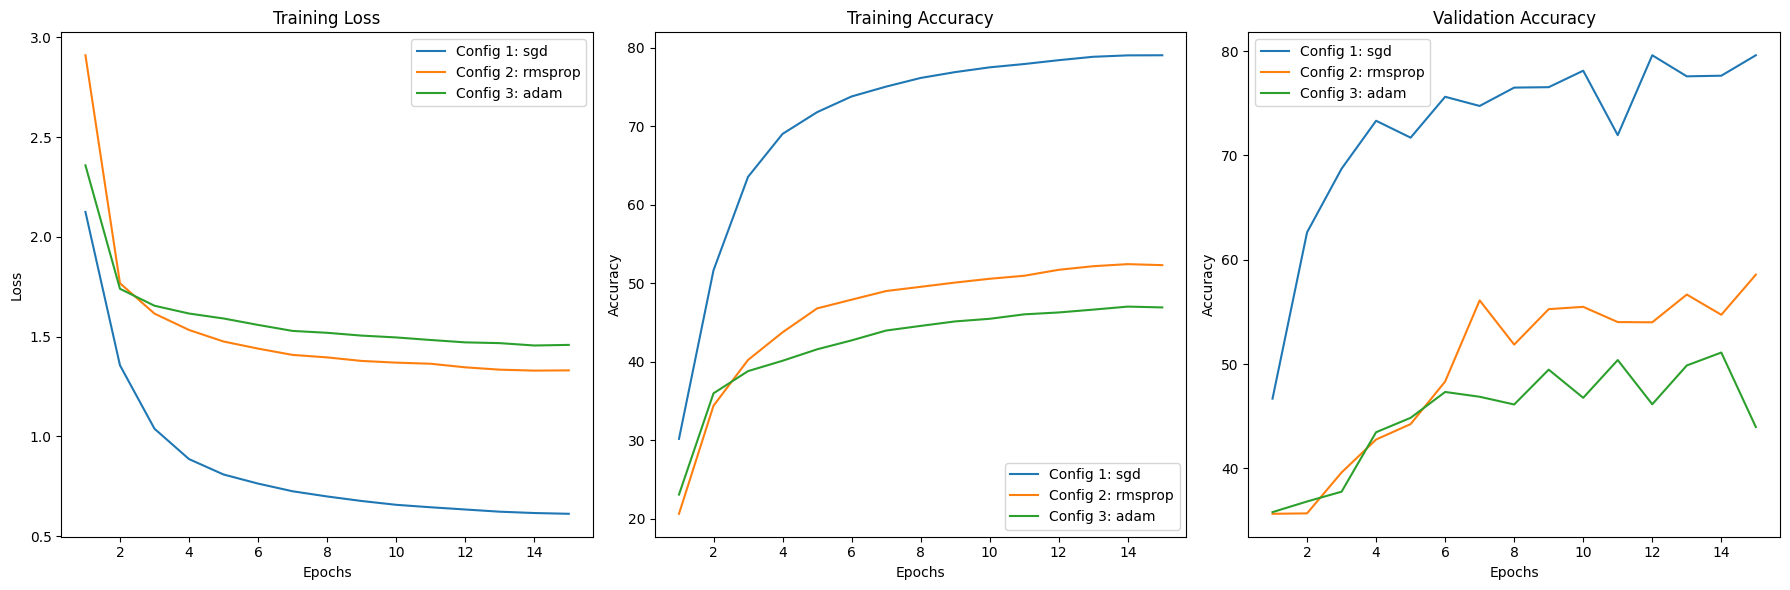

In [189]:
plot_training_results(results4, epochs, optimizers)

### <center> 1.2.5 a best model </center>

如果不改变输入图片的大小：

In [10]:
transform = transforms.Compose([
            # transforms.Resize((64, 64)),
            transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
            transforms.RandomHorizontalFlip(p=0.6),
            transforms.ToTensor(),# 随机水平翻转 选择一个概率概率
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # 均值，标准差
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

torch.manual_seed(42)
trainset, valset = random_split(trainset, [train_size, val_size])
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [11]:

from torch import nn

def init_weights_(m):
    """
    Initializes weights of m according to Xavier normal method.

    :param m: module
    :return:
    """
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ## Models implementation
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()

    return parameters_n

In [20]:
class bestnet(nn.Module):
    def __init__(self, cfg = ["R", "R", "R"], output_channel = 256, output_feature = 4, Global_pool = False, init_weights=True):
        super(bestnet, self).__init__()
        self.Global = Global_pool
        self.cfg = cfg
        ## 第一层
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding = 3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b2 = nn.Sequential(nn.Dropout(0.6),
            # nn.Linear(128, 128),
            nn.Linear(128, 10))
                                
        # 有无平均池化
        if Global_pool:
            self.classifier = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Conv2d(output_channel, 128, kernel_size=1)
            )
        else:
            self.classifier = nn.Sequential(
                    nn.Dropout(0.5),
                    # nn.Linear(output_channel*8, 512),
                    nn.Linear(output_channel*output_feature, 1024),
                    # nn.Linear(1024, 1024),
                    nn.Dropout(0.8),
                    nn.Linear(1024, 512),
                    # nn.Dropout(0.8),
                    nn.Linear(512, 10)
            )
        self.input_channel = 64
        self.layers = self.make_layer()
        if init_weights:
            self._init_weights()
    def make_layer(self):
        layers = []
        for i in range(len(self.cfg)):
            if self.cfg[i] == "R":
                if i == 0 or self.cfg[i-1] != "R": # 如果前面高宽减半就别再res里减半
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel, 2, first_block=True)))

                else:
                    layers.append(nn.Sequential(*resnet_block(self.input_channel, self.input_channel*2, 2)))
                    self.input_channel *= 2
                
            else:
                layers.append(Convblock(self.input_channel, self.input_channel*2, 2))
                self.input_channel *= 2 
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.b1(x)
        out = self.layers(out)
        if self.Global:
            out = self.classifier(out)
            out = out.view(out.size(0), -1)
            out = self.b2(out)  
        else:
            out = self.pool(out)
            out = out.view(out.size(0), -1)
            out = self.classifier(out)
        return out
    
    def _init_weights(self):
        for m in self.modules():
            init_weights_(m)

In [13]:
import time 
def train(net, trainloader, valloader, num_epochs,optimizer,scheduler):

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val = 0
    max_model = None
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        net.train()  # 设置为训练模式
        running_loss = 0.0
        correct = 0
        total = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # 验证阶段
        net.eval()  # 设置为评估模式
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        scheduler.step()
        if max_val < val_acc:
            max_val = val_acc
            max_model = net
            torch.save(net.state_dict(), 'checkpoint/cifar10_bestnet1.pth')
        epoch_end = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_end - epoch_start:.3f}s')

    return max_model, train_losses, train_accuracies, val_accuracies

In [21]:
import torch.optim as optim
# 超参数的设定
num_epochs = 100 # 训练轮数
learning_rate = 1e-3     # 初始学习率
best_net = bestnet(Global_pool=True)
if torch.cuda.is_available():
    best_net = best_net.cuda()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(best_net.parameters(), lr=learning_rate, weight_decay=5e-3)
optimizer = optim.SGD(best_net.parameters(), lr=learning_rate, momentum=0.95, weight_decay=5e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                            milestones=[int(num_epochs*0.3), int(num_epochs*0.6)],
                                            gamma=0.1, last_epoch=-1)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
#                                             milestones=[int(num_epochs*0.3), int(num_epochs*0.80)], last_epoch=-1)

In [149]:
print(get_number_of_parameters(bestnet(Global_pool=True)))

2810762


In [150]:
best_net_get, best_train_losses, best_train_accuracies, best_val_accuracies = train(best_net, trainloader, valloader, num_epochs, optimizer, scheduler)

Epoch: 1/100
Epoch [1/100], Train Loss: 1.8955, Train Acc: 33.76%, Val Acc: 46.27%, Time: 5.357s
Epoch: 2/100
Epoch [2/100], Train Loss: 1.4615, Train Acc: 47.07%, Val Acc: 53.52%, Time: 5.583s
Epoch: 3/100
Epoch [3/100], Train Loss: 1.3084, Train Acc: 52.95%, Val Acc: 56.73%, Time: 5.352s
Epoch: 4/100
Epoch [4/100], Train Loss: 1.1971, Train Acc: 57.79%, Val Acc: 59.79%, Time: 5.424s
Epoch: 5/100
Epoch [5/100], Train Loss: 1.1232, Train Acc: 60.48%, Val Acc: 62.12%, Time: 5.380s
Epoch: 6/100
Epoch [6/100], Train Loss: 1.0567, Train Acc: 62.83%, Val Acc: 64.84%, Time: 5.480s
Epoch: 7/100
Epoch [7/100], Train Loss: 1.0068, Train Acc: 64.75%, Val Acc: 64.40%, Time: 5.441s
Epoch: 8/100
Epoch [8/100], Train Loss: 0.9520, Train Acc: 66.67%, Val Acc: 67.56%, Time: 5.360s
Epoch: 9/100
Epoch [9/100], Train Loss: 0.9175, Train Acc: 68.08%, Val Acc: 67.41%, Time: 5.337s
Epoch: 10/100
Epoch [10/100], Train Loss: 0.8835, Train Acc: 69.41%, Val Acc: 69.54%, Time: 5.448s
Epoch: 11/100
Epoch [11/100]

In [84]:
correct = 0
total = 0

model_path = './checkpoint/cifar10_bestnet.pth'
best_net.load_state_dict(torch.load(model_path))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 82.31%


### <center>insight </center>

#### <center> visualization of filters <center>

我们将可视化第一个 Resblock 中的第一个卷积层 和 b1 中的第一个卷积层

In [50]:
checkpoint_path = "./checkpoint/cifar10_test_mynet.pth"
model_state_dict = torch.load(checkpoint_path)
test_net.load_state_dict(model_state_dict)

<All keys matched successfully>

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


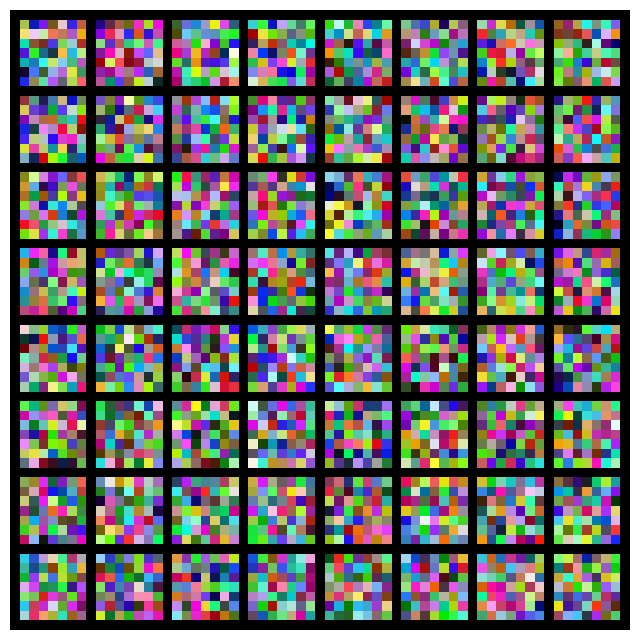

In [55]:
# 访问b1 中的第一个卷积层
layer_index = 0
resblock_index = 0
conv_layer1 = net.b1[0]

# 提取卷积层的权重
filter = conv_layer1.weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

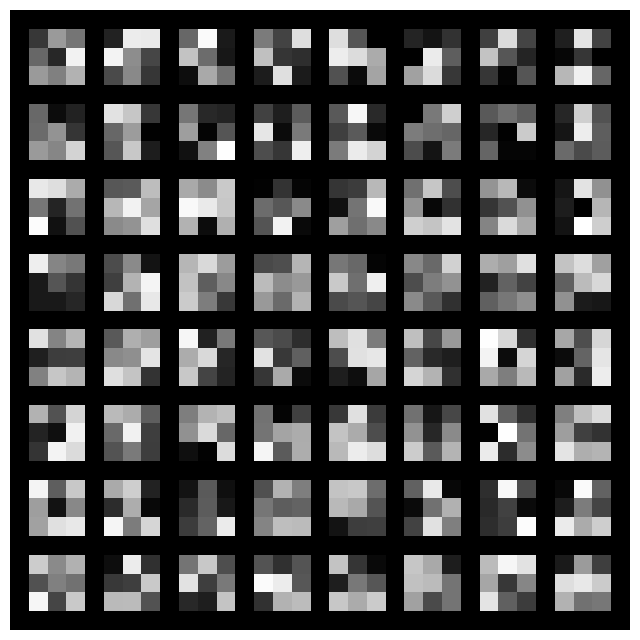

In [52]:
# 访问第一个 Resblock 中的第一个卷积层
layer_index = 0
resblock_index = 0
conv_layer1 = net.layers[layer_index][resblock_index].conv1

# 提取卷积层的权重
filter = conv_layer1.weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

#### <center> saliency_maps </center>

首先在best_net上试一下saliency_map:

In [86]:
testset2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=5, shuffle=False, num_workers=2)

# 使用迭代器语法获取第一批数据
data_iter = iter(testloader2)
_,_ = next(data_iter)
X, y = next(data_iter)

print(X.size())
print(y.size())

Files already downloaded and verified
torch.Size([5, 3, 32, 32])
torch.Size([5])


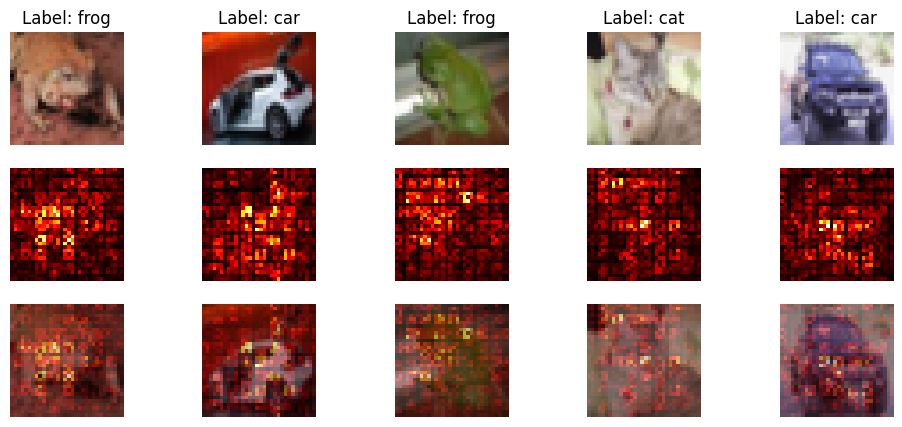

In [87]:
show_saliency_maps(X, y, best_net)

可以看到在图像重点地方越红，frog,cat 重点在头部和身体，car重点在车头和车身

但是由于分辨率不够高，导致效果不是很好，我们再用一开始的test_net试一下

In [127]:
checkpoint_path = "./checkpoint/cifar10_test_mynet1.pth"
model_state_dict = torch.load(checkpoint_path)
test_net.load_state_dict(model_state_dict)
torch.manual_seed(43)
testset1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
    transforms.Resize((224,224))]))
testloader1 = torch.utils.data.DataLoader(testset1, batch_size=5, shuffle=False, num_workers=2)
data_iter = iter(testloader1)
_,_ = next(data_iter)
X1, y1 = next(data_iter)

print(X1.size())
print(y1.size())

Files already downloaded and verified


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

torch.Size([5, 3, 224, 224])
torch.Size([5])


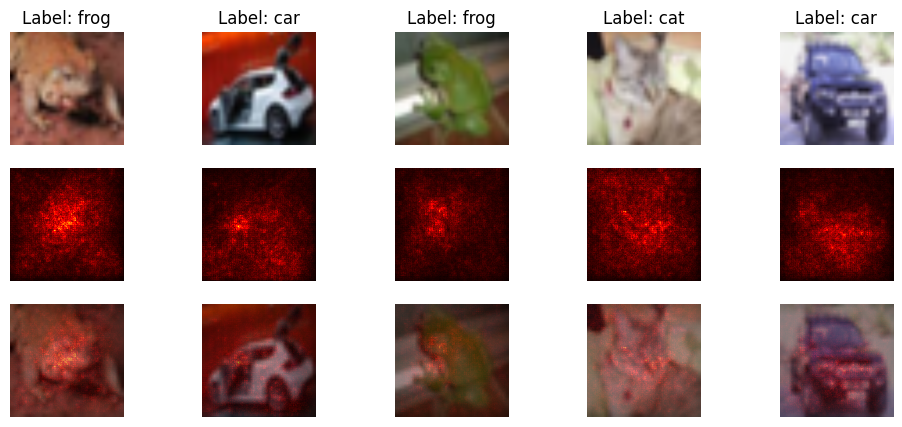

In [128]:
show_saliency_maps(X1, y1, test_net.to(device))

可以看到saliency_map红色区域集中在有图像的地方，而且已经有一个大致的轮廓，说明网络可以较好的分辨图片的重点位置来获取特征进行分类

#### <center> class visualization </center>

接下来我们可以可视化每个类别的特征（用test_net实现）通过网络和类别来反向生成图片

我们以cat为例来看逐步生成的过程

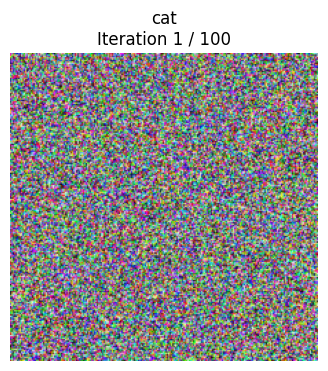

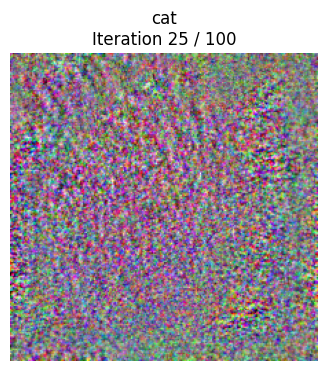

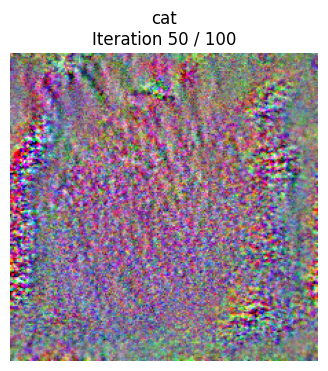

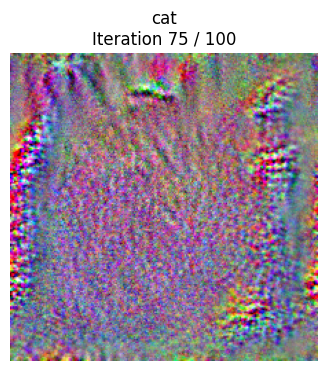

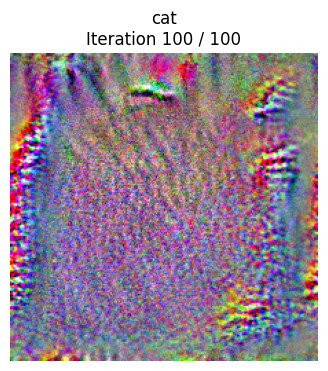

In [123]:
dtype = torch.FloatTensor
test_net.type(dtype)

target_y = 3 # cat
out = create_class_visualization(target_y, test_net, dtype)

最后我们可以得到所有的图：
<div style="display:flex; justify-content:center;">
    <img src="./visualize/figure/bird.png" alt="Image 6" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/car.png" alt="Image 11" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/cat.png" alt="Image 12" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/deer.png" alt="Image 12" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/dog.png" alt="Image 12" style="height:200px; margin: 10px;" />
</div>

<div style="display:flex; justify-content:center;">
    <img src="./visualize/figure/frog.png" alt="Image 6" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/horse.png" alt="Image 11" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/plane.png" alt="Image 12" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/ship.png" alt="Image 12" style="height:200px; margin: 10px;" />
    <img src="./visualize/figure/truck.png" alt="Image 12" style="height:200px; margin: 10px;" />
</div>

# <center>2. Batch Normalization </center>
Batch Normalization (BN) is a widely adopted technique that enables faster and more stable training of deep
neural networks (DNNs). The tendency to improve accuracy and speed up training have established BN as a
favorite technique in deep learning. At a high level, BN is a technique that aims to improve the training of neural
networks by stabilizing the distributions of layer inputs. This is achieved by introducing additional network layers
that control the first two moments (mean and variance) of these distributions.
In this project, you will first test the effectiveness of BN in the training process, and then explore how does BN
help optimization. The sample codes are provided by Python.

## 2.1 The Batch Normalization Algorithm
### Dataset. 

To investigate batch normalization we will use following experimental setup: image classification on
CIFAR-10 with a network has the same architecture as VGG-A except the size of Linear layers is smaller since
input assumed to be 32 × 32 × 3, instead of 224 × 224 × 3. And all sample codes are implemented based on Pytorch.
You can run loaders.py to download CIFAR-10 dataset, and output some examples to familiarize yourself with
the data storage format. Note that if you are using a remote server, you need to use matplotlib.pyplot.savefig()
function to save the plot results, and then download to local to view.


## 2.2 VGG-A with and without BN (15%)
In this section, you will compare the performance and characteristics of VGG-A with and without BN. We encourage
you to extend and modify the provided code for clearer and more convincing experimental results. Note that you
should understand the code first instead of using it as a black box.

If you want to use partial dataset to train for faster results, set n_items to meet your wish. The basic VGG-A
network is implemented in VGG.py, you can train this network first to understand the overall network architecture
and view the training results. Then write a class VGG_BatchNorm to add the BN layers to the original network,
and finally visualize the training results of the two for comparison. Sample code for training and visualizing has
been included in VGG_Loss_Landscape.py.

先测试一下

cuda:3

NVIDIA RTX A6000

Files already downloaded and verified

Files already downloaded and verified

可以正常输出tensor和图片：
<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/sample.png" alt="Image 1" style="height:200px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/tensor.png" alt="Image 3" style="height:200px; margin: 10px;" />
</div>




对VGG_A VGG_A_Light VGG_A_Dropout 都补充了加BN的版本 这部分代码在VGG_BAtchNorm里

每一类我们都对比画了四张图：

1. Loss landscape or variation of the value of the loss;
2. Gradient predictiveness or the change of the loss gradient;
3. Maximum difference in gradient over the distance.
4. learning accuarcy


相关的输出都保存在/VGG_BatchNorm/output里

对于VGG_A:

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/A/loss_landscape_comparison.png" alt="Image 6" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/A/gd_pd_comparison.png" alt="Image 11" style="height:250px; margin: 10px;" />
</div>

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/A/effective β-smoothness.png" alt="Image 3" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/A/train learning accuracy.png" alt="Image 1" style="height:250px; margin: 10px;" />
</div>

而对于VGG_A和VGG_A_BN，我们也画了对应的函数(对于D和L都在各自文件夹里)

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/withoutBN_A/Gd_predictness.png" alt="Image 6" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/withoutBN_A/grad_changes_all.png" alt="Image 11" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/withoutBN_A/loss_landscape_all.png" alt="Image 12" style="height:250px; margin: 10px;" />
</div>

<center> A without BN </center>

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/withBN_A/Gd_predictness.png" alt="Image 6" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/withBN_A/grad_changes_all.png" alt="Image 11" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/withBN_A/loss_landscape_all.png" alt="Image 12" style="height:250px; margin: 10px;" />
</div>

<center> A with BN </center>

对于VGG_Light:

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/L/loss_landscape_comparison.png" alt="Image 6" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/L/gd_pd_comparison.png" alt="Image 11" style="height:250px; margin: 10px;" />
</div>

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/L/effective β-smoothness.png" alt="Image 3" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/L/train learning accuracy.png" alt="Image 1" style="height:250px; margin: 10px;" />
</div>

对于VGG_Dropout:

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/D/loss_landscape_comparison.png" alt="Image 6" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/D/gd_pd_comparison.png" alt="Image 11" style="height:250px; margin: 10px;" />
</div>

<div style="display:flex; justify-content:center;">
    <img src="./VGG_BatchNorm/output/figure/D/effective β-smoothness.png" alt="Image 3" style="height:250px; margin: 10px;" />
    <img src="./VGG_BatchNorm/output/figure/D/train learning accuracy.png" alt="Image 1" style="height:250px; margin: 10px;" />
</div>

我们可以看出 使用BN的网络都提高了性能和损失图的平滑度。